In [2]:
import yfinance as yf
import pandas as pd
import numpy as np 
import warnings
import optuna
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error


from data_downloader import DataDownloader, ClimateDataCleaner, EconomicDataCleaner
from var_model import ClimateVAR
from sdice_model import SimplifiedDICE

In [3]:
# Instancia para limpiar y procesar los datos climáticos
climate_cleaner = ClimateDataCleaner('Data/Temperature.csv', 'Data/Drought_Severity.csv', 'Data/CO2_Emissions.xlsx')
climate_data = climate_cleaner.clean_and_prepare_data()

# Instancia para limpiar y procesar los datos climáticos
economic_cleaner = EconomicDataCleaner('Data/GDP.csv', 'Data/TB3MS.csv', 'Data/CPI.csv')
economic_data = economic_cleaner.clean_and_prepare_data()

# Descarga los datos financieros
downloader = DataDownloader()
assets = ['AAPL', 'IBM', 'TSLA', 'GOOG', 'NVDA', 'NEE', 'FSLR', 'VWDRY', 'BEP'] 
benchmark = '^GSPC'  
start_date = '2014-11-01'
end_date = '2024-05-31'
rf = .065

asset_prices, benchmark_prices = downloader.download_data(start_date=start_date, 
                                                          end_date=end_date, 
                                                          assets=assets, 
                                                          benchmark=benchmark)

combined_data = pd.merge(asset_prices, climate_data, on='Date').iloc[:-1]
all_data = pd.merge(combined_data, economic_data, on='Date')


[*********************100%%**********************]  9 of 9 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
all_data.drop('Date', axis=1, inplace=True)

In [5]:
# Definir la función objetivo para Optuna
def objective(trial):
    # Elige el número de retardos entre 1 y 10
    maxlags = trial.suggest_int('maxlags', 1, 10)

    # Ajustar el modelo VAR con el número de retardos sugerido
    var_model = ClimateVAR(all_data)
    var_results = var_model.fit(maxlags=maxlags)

    # Realizar predicciones con el número de retardos sugerido
    predicted = var_model.predict(var_results, lags=maxlags, end=100)

    # Definir los valores reales (esto es solo un ejemplo, debes usar tus valores reales)
    actual = all_data[maxlags:100]  # Ajusta según la longitud de tus datos

    # Asegurarse de que predicted y actual tengan la misma longitud
    min_len = min(len(predicted), len(actual))
    predicted = predicted[:min_len]
    actual = actual[:min_len]

    # Calcular el error de predicción (RMSE)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    return rmse

# Crear el estudio de Optuna para minimizar el RMSE
study = optuna.create_study(direction='minimize')

# Ejecutar la optimización
study.optimize(objective, n_trials=100)

# Imprimir el número óptimo de retardos
print(f'Número óptimo de retardos: {study.best_trial.params["maxlags"]}')
print(f'RMSE óptimo: {study.best_value}')

# Ajustar el modelo VAR con el número óptimo de retardos
optimal_maxlags = study.best_trial.params["maxlags"]
var_model = ClimateVAR(all_data)
var_results = var_model.fit(maxlags=optimal_maxlags)

# Realizar predicción futura con el número óptimo de retardos
predict = var_model.predict(var_results, lags=optimal_maxlags, end=100)

# Imprimir los valores predichos
print("Valores predichos:")
print(predict)

[I 2024-09-20 21:13:40,400] A new study created in memory with name: no-name-bb22cbdc-f413-4684-911b-54eeede710e9
[I 2024-09-20 21:13:40,438] Trial 0 finished with value: 3.131371495840718e-09 and parameters: {'maxlags': 8}. Best is trial 0 with value: 3.131371495840718e-09.
[I 2024-09-20 21:13:40,459] Trial 1 finished with value: 3.3554027749379104e-08 and parameters: {'maxlags': 6}. Best is trial 0 with value: 3.131371495840718e-09.
[I 2024-09-20 21:13:40,463] Trial 2 finished with value: 25.98793807057078 and parameters: {'maxlags': 5}. Best is trial 0 with value: 3.131371495840718e-09.
[I 2024-09-20 21:13:40,470] Trial 3 finished with value: 3.3554027749379104e-08 and parameters: {'maxlags': 6}. Best is trial 0 with value: 3.131371495840718e-09.
[I 2024-09-20 21:13:40,477] Trial 4 finished with value: 5.184551178889765e-09 and parameters: {'maxlags': 7}. Best is trial 0 with value: 3.131371495840718e-09.
[I 2024-09-20 21:13:40,483] Trial 5 finished with value: 54.9759292064323 and 

[I 2024-09-20 21:13:40,952] Trial 50 finished with value: 5.184551178889765e-09 and parameters: {'maxlags': 7}. Best is trial 0 with value: 3.131371495840718e-09.
[I 2024-09-20 21:13:40,963] Trial 51 finished with value: 3.131371495840718e-09 and parameters: {'maxlags': 8}. Best is trial 0 with value: 3.131371495840718e-09.
[I 2024-09-20 21:13:40,986] Trial 52 finished with value: 3.818149608557295e-09 and parameters: {'maxlags': 9}. Best is trial 0 with value: 3.131371495840718e-09.
[I 2024-09-20 21:13:41,002] Trial 53 finished with value: 3.131371495840718e-09 and parameters: {'maxlags': 8}. Best is trial 0 with value: 3.131371495840718e-09.
[I 2024-09-20 21:13:41,013] Trial 54 finished with value: 5.184551178889765e-09 and parameters: {'maxlags': 7}. Best is trial 0 with value: 3.131371495840718e-09.
[I 2024-09-20 21:13:41,024] Trial 55 finished with value: 3.818149608557295e-09 and parameters: {'maxlags': 9}. Best is trial 0 with value: 3.131371495840718e-09.
[I 2024-09-20 21:13:41

Número óptimo de retardos: 8
RMSE óptimo: 3.131371495840718e-09
Valores predichos:
[[-6.61962755e-02 -7.69780265e-03  7.99097286e-02 ...  1.84016260e+04
   3.00000000e-02  2.38034000e+02]
 [-2.18162946e-02 -2.86219459e-02 -1.06396324e-01 ...  1.84016260e+04
   3.00000000e-02  2.38034000e+02]
 [ 8.34088789e-02 -4.03781158e-02  3.34970753e-01 ...  1.84351370e+04
   2.00000000e-02  2.37733000e+02]
 ...
 [ 2.31829813e-02 -9.24475412e-02 -4.76351713e-02 ...  2.68136010e+04
   4.54000000e+00  3.00356000e+02]
 [ 1.18648854e-01  2.06355232e-01  2.85916996e-01 ...  2.68136010e+04
   4.54000000e+00  3.00356000e+02]
 [ 2.89870711e-02 -1.61853981e-02 -1.60551716e-01 ...  2.70630120e+04
   4.92000000e+00  3.03032000e+02]]


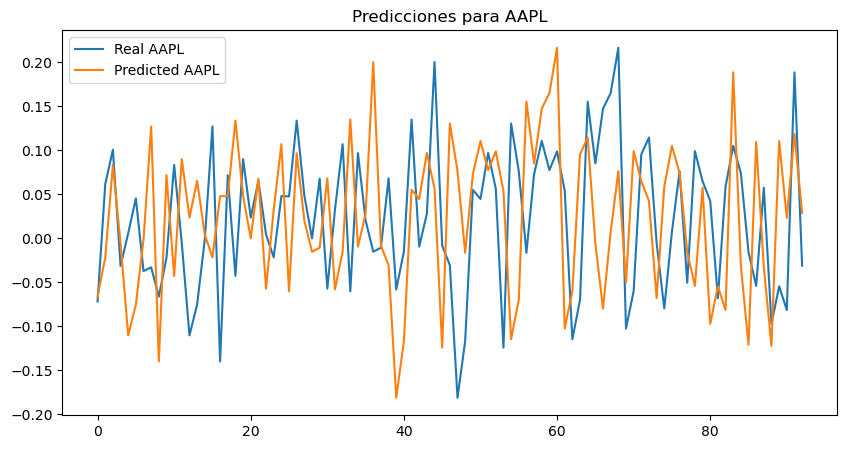

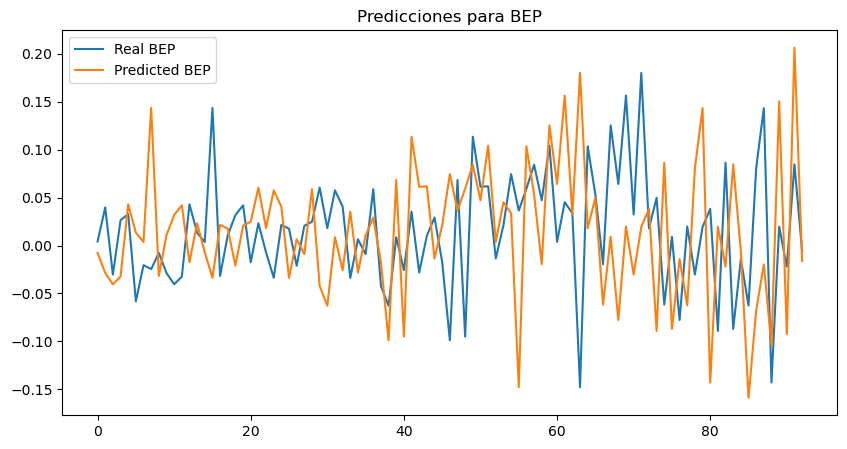

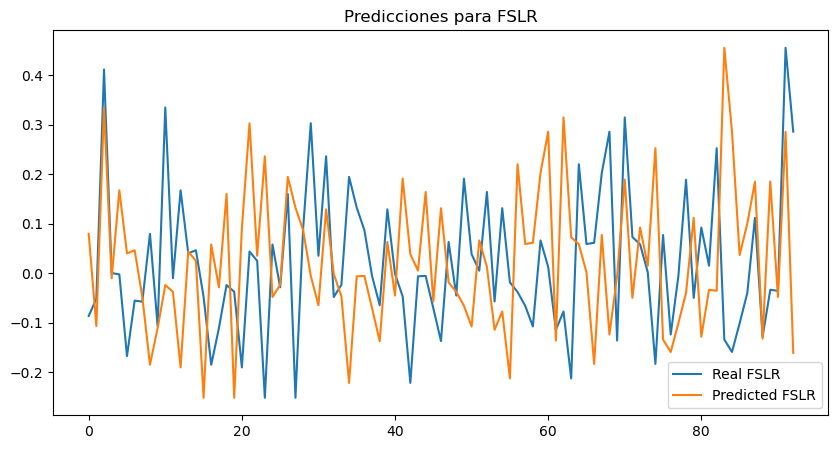

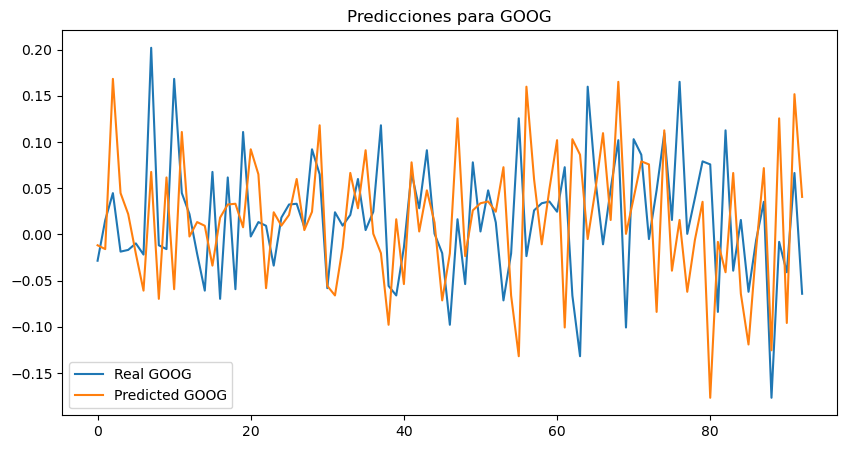

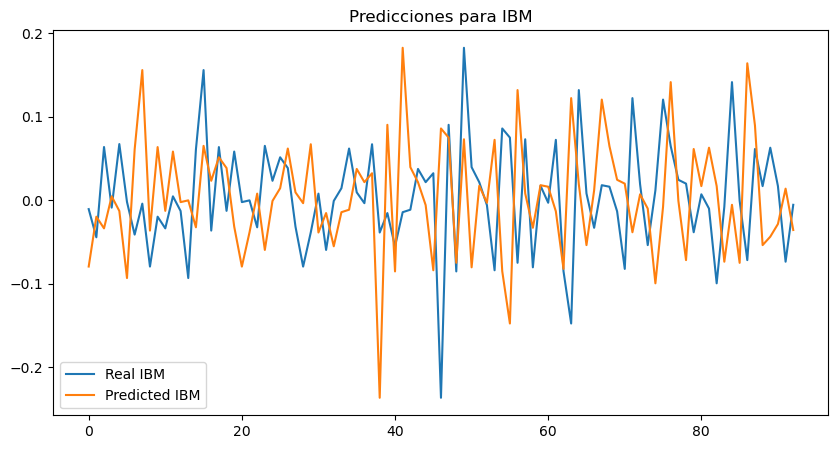

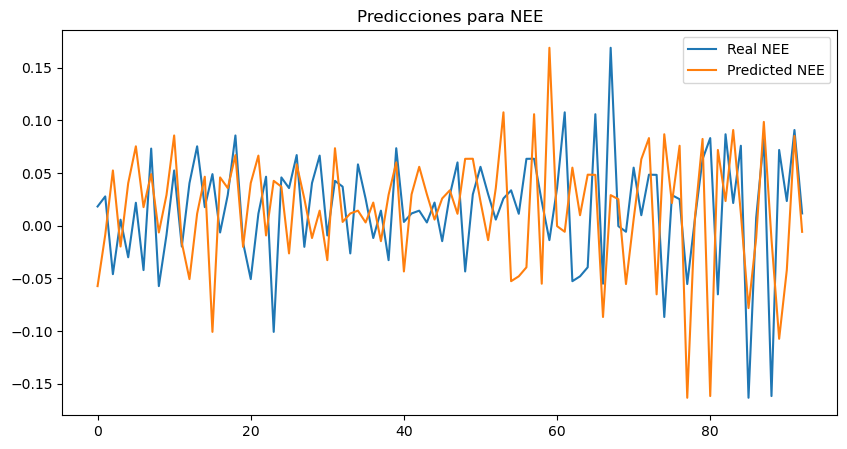

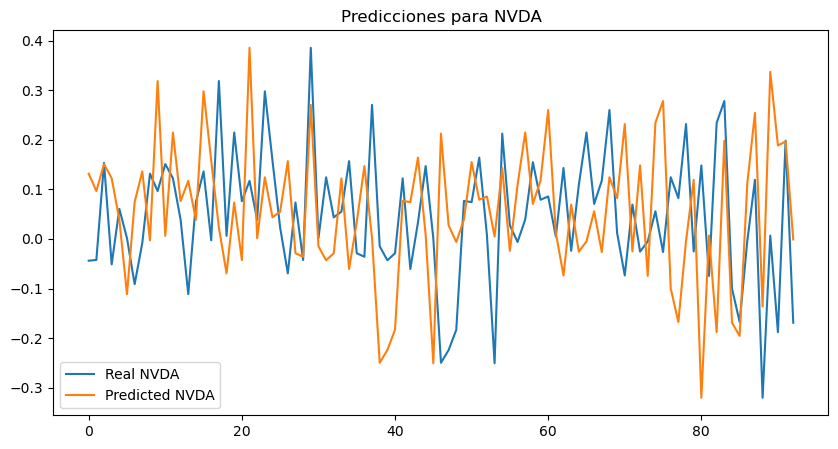

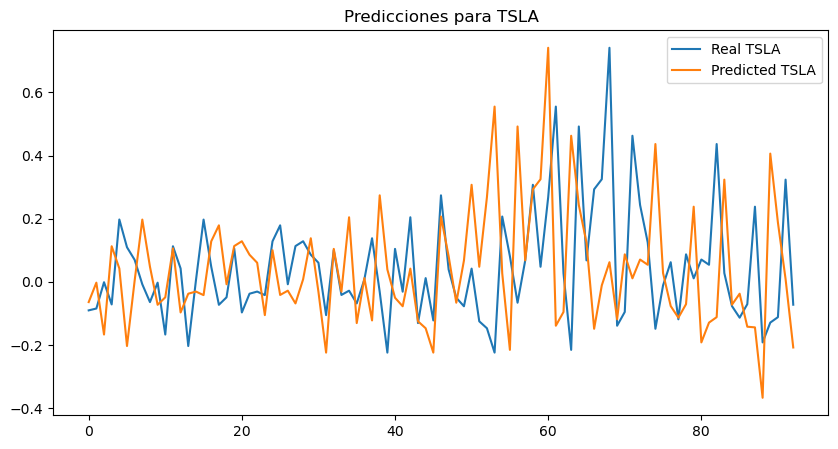

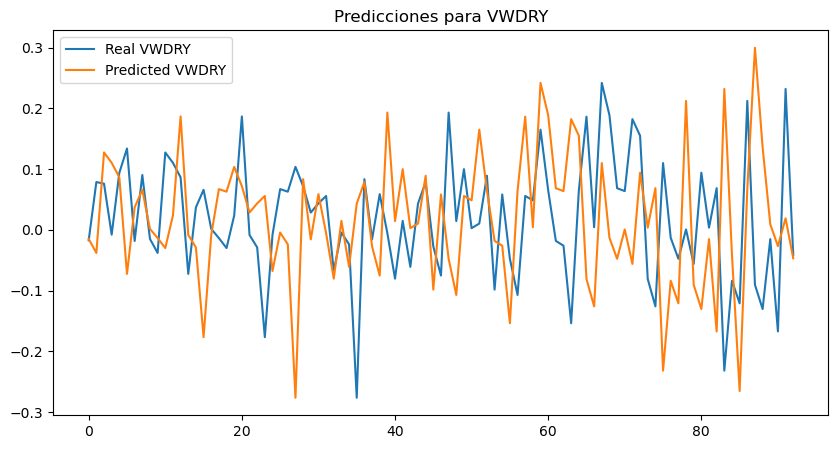

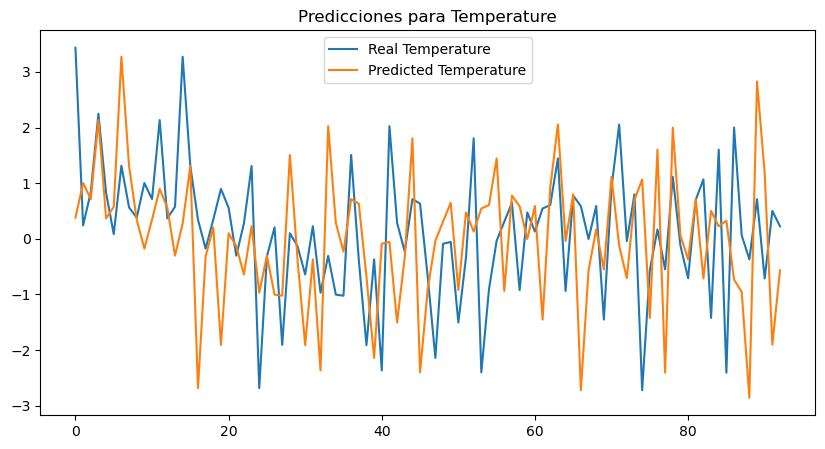

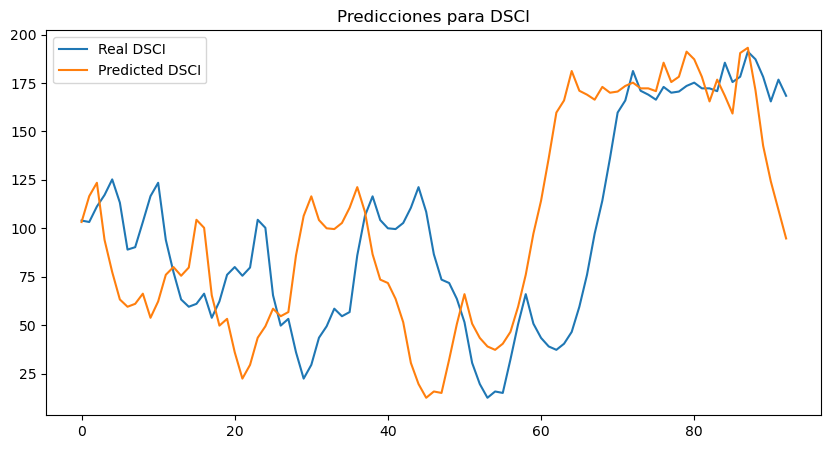

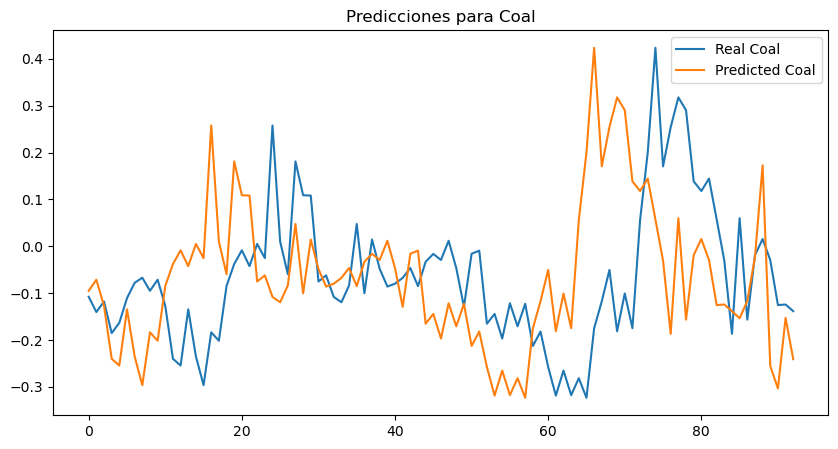

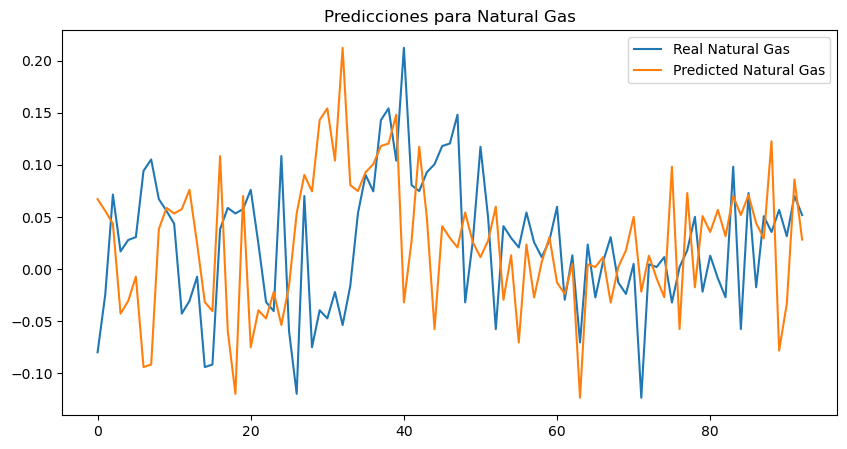

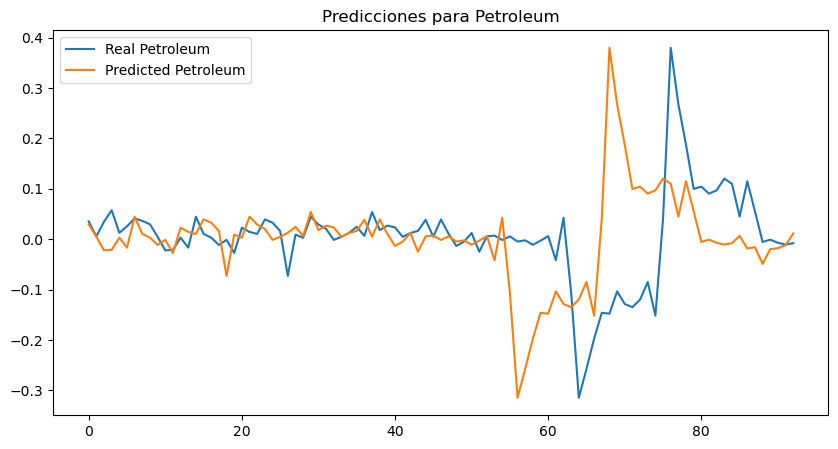

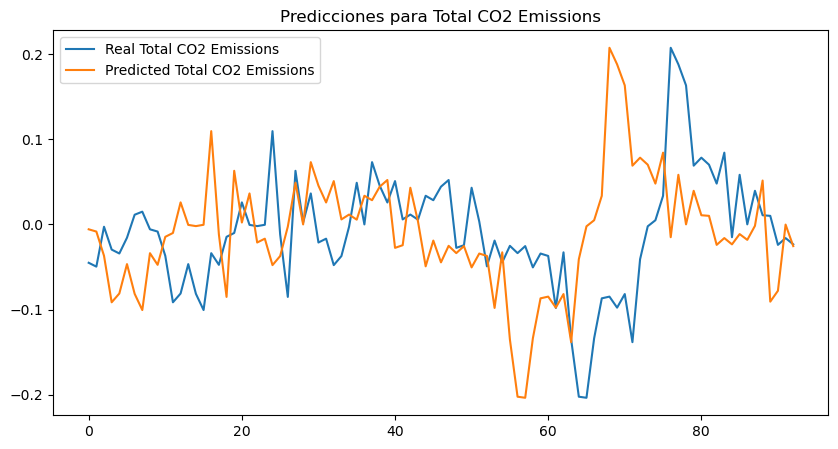

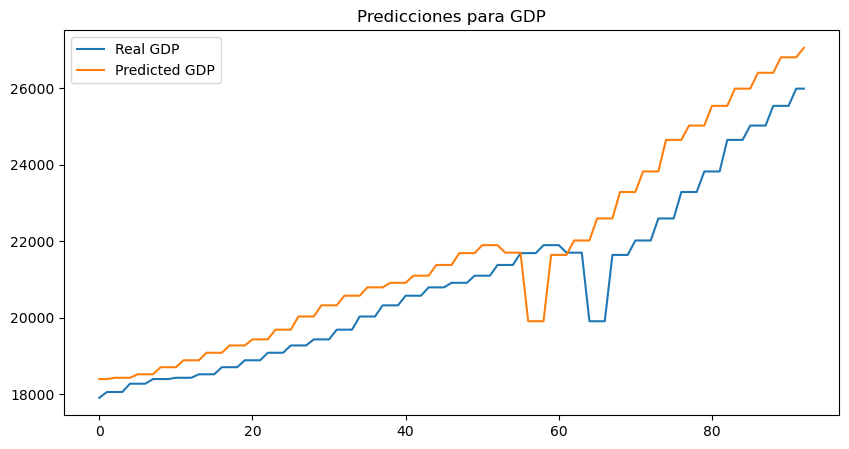

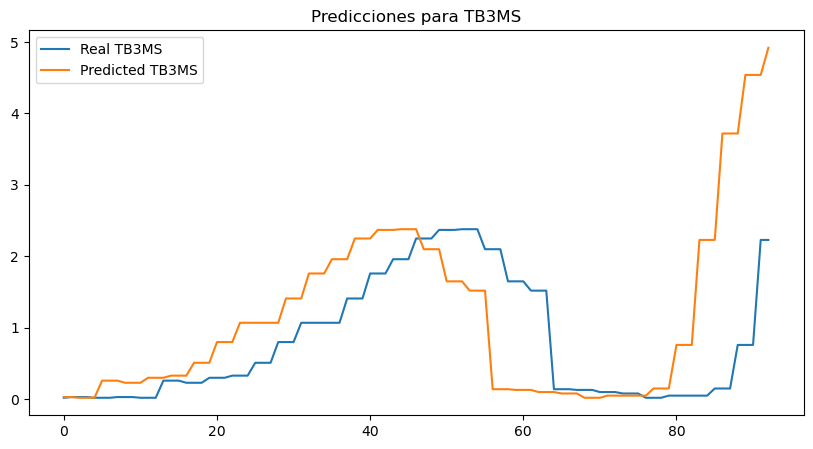

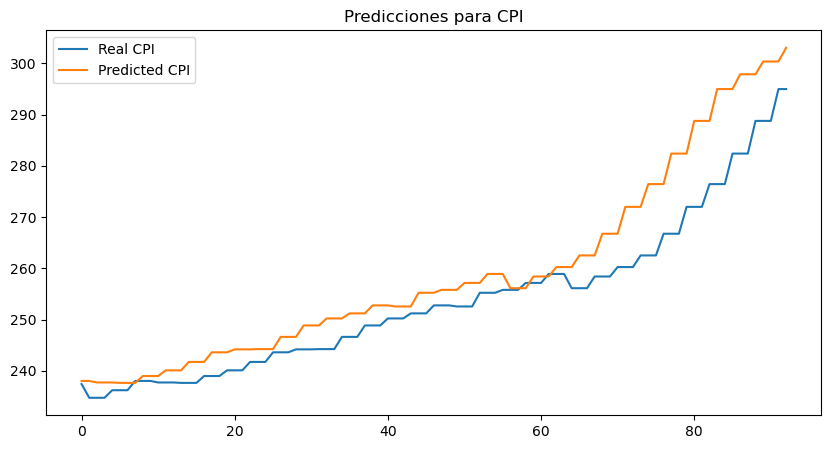

In [6]:
import matplotlib.pyplot as plt

# Graficar las predicciones versus los datos originales
for i, column in enumerate(all_data.columns):
    plt.figure(figsize=(10, 5))
    plt.plot(all_data.index[:len(predict)], all_data.iloc[:len(predict), i], label=f"Real {column}")
    plt.plot(all_data.index[:len(predict)], predict[:, i], label=f"Predicted {column}")
    plt.title(f"Predicciones para {column}")
    plt.legend()
    plt.show()


In [ ]:
asset_prices.plot(x='Date', y=assets, figsize=(14, 7), title='Asset Returns')